This notebook contains the preprocessing and modelling of a dataset that contains 70 different time series, where one series is taken and with three different tecniques, we predict the trend and sales count of that time series.

# Importing Libraries

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import missingno as mno
import numpy as np
import time
import mplcyberpunk
plt.style.use('cyberpunk')
import math
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [95]:
from statsmodels.graphics.tsaplots import plot_pacf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [96]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Import data

In [97]:
data_train =pd.read_csv(r"C:\Users\Ashinth\Documents\courses\Kaggle\competetions\TS forecasting store sales\mini TS\train.csv")
data_test =pd.read_csv(r"C:\Users\Ashinth\Documents\courses\Kaggle\competetions\TS forecasting store sales\mini TS\test.csv")

In [98]:
data_train.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


# EDA

**The number of days**

In [99]:
len(data_train.Date.unique())

3287

**The number of stores**

In [100]:
data_train.store.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [101]:
len(data_train.store.unique())

7

**The number of products**

In [102]:
data_train['product'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [103]:
len(data_train['product'].unique()) # product is a pandas keyword

10

## Timesteps

In [104]:
days_train=len(data_train.Date.unique())
days_test=len(data_test.Date.unique())

time=np.zeros((days_train,1))
time_test=np.zeros((days_test,1))

for i in range(days_train):
    time[i]=i

for i in range(days_test):
    time_test[i]=i+days_train

for stores in data_train.store.unique():
    for products in data_train['product'].unique():
        indices=data_train[(data_train.store==stores) & (data_train['product']==products)].index
        data_train.loc[indices,'time']=time

        indices_test=data_test[(data_test.store==stores) & (data_test['product']==products)].index
        data_test.loc[indices_test,'time']=time_test

The timestep would increase after each of the family in each store is being covered, hence we create a database, where we keep lists of sales of each family in each store over each timestep


# Modelling and Predicting the best models

**taking the first product of the first store**

In [138]:
y_train=data_train[(data_train.store==0) & (data_train['product']==3)].number_sold

### Sales vs time

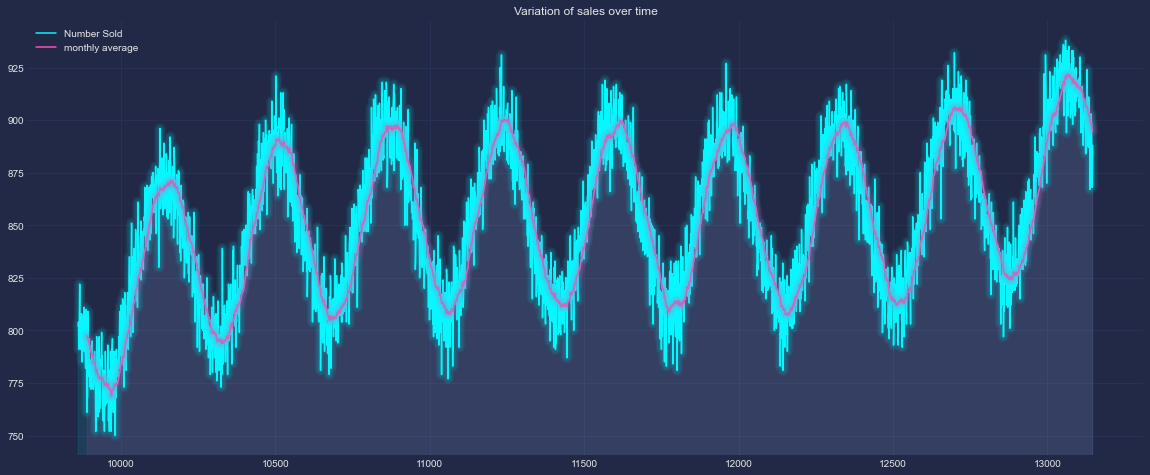

In [139]:
fig,ax=plt.subplots(figsize=[20,8])
ax.plot(y_train,label="Number Sold")
avg_month=y_train.rolling(30).mean()
ax.plot(avg_month,label="monthly average")
ax.legend()
ax.set_title("Variation of sales over time")
mplcyberpunk.add_glow_effects()

## The partial autocorrelation plot

c:\Users\Ashinth\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


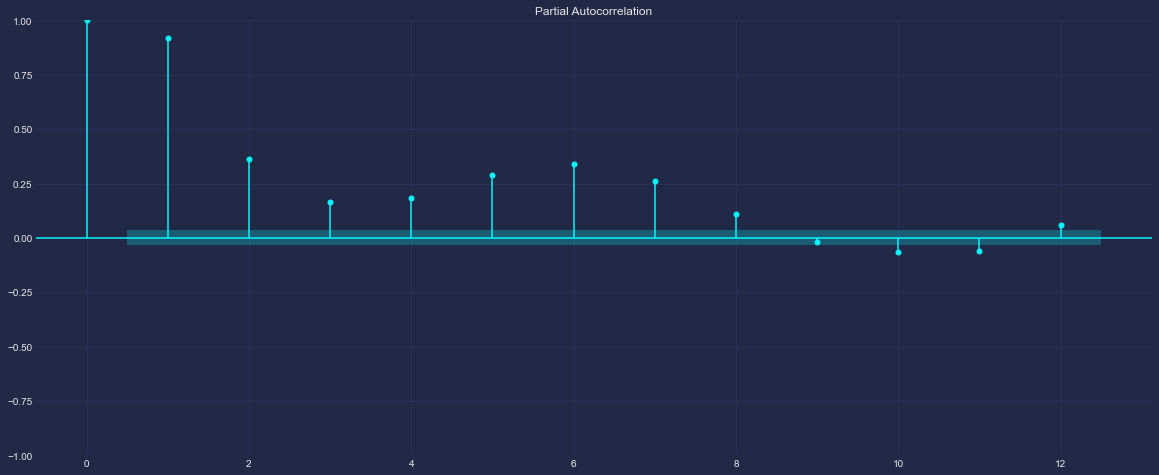

In [140]:
fig,ax= plt.subplots(figsize=[20,8])
_ = plot_pacf(y_train, lags=12,ax=ax)

## taking the lags from the above plot

In [141]:
def make_lags(ts, lags):
    return pd.concat(
        {f'y_lag_{i}': ts.shift(i) for i in range(1, lags + 1)},
        
        axis=1)


X_train = make_lags(y_train, lags=8)
X_train= X_train.fillna(X_train.mean())

In [142]:
X_val=X_train.iloc[int(0.8*len(X_train)):int(len(X_train))]
y_val=y_train[int(0.8*len(y_train)):int(len(y_train))]

X_train=X_train.iloc[0:int(0.8*len(X_train))]
y_train=y_train[0:int(0.8*len(y_train))]


## 1. The ANN model

In [168]:
scalerX=MinMaxScaler()
scalerY=MinMaxScaler()

X_train_1, y_train_1 = np.array(X_train), np.array(y_train)
X_val_1, y_val_1 = np.array(X_val), np.array(y_val)

X_train_1=scalerX.fit_transform(X_train_1)
y_train_1=scalerY.fit_transform(y_train_1.reshape(-1,1))
X_val_1=scalerX.transform(X_val_1)
y_val_1=scalerY.transform(y_val_1.reshape(-1,1))

In [169]:
# The ANN model
model = Sequential()
model.add(Dense(units=4, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Dense(1))
opt = keras.optimizers.Adadelta(learning_rate=0.1)
model.compile(optimizer=opt, loss='mean_squared_error', metrics= ['accuracy'])
#early_stopping=EarlyStopping( min_delta=0.1, patience=30 ,restore_best_weights=True)

In [170]:
model.fit(X_train_1, y_train_1, batch_size=50, verbose = 1, epochs = 200, validation_data= (X_val_1, y_val_1))#callbacks=[early_stopping])

Epoch 1/200
53/53 [==============================] - 1s 6ms/step - loss: 0.3224 - accuracy: 3.8037e-04 - val_loss: 0.4691 - val_accuracy: 0.0000e+00
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 0.3135 - accuracy: 3.8037e-04 - val_loss: 0.4584 - val_accuracy: 0.0000e+00
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.3032 - accuracy: 3.8037e-04 - val_loss: 0.4367 - val_accuracy: 0.0000e+00
Epoch 4/200
53/53 [==============================] - 0s 3ms/step - loss: 0.2428 - accuracy: 3.8037e-04 - val_loss: 0.2399 - val_accuracy: 0.0000e+00
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 7.6075e-04 - val_loss: 0.0337 - val_accuracy: 0.0030
Epoch 6/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 7.6075e-04 - val_loss: 0.0265 - val_accuracy: 0.0030
Epoch 7/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0191 - accuracy: 7.6075e-04 - val_loss:

In [171]:
train_preds=model.predict(X_train_1)
val_preds=model.predict(X_val_1)

21/21 [==============================] - 0s 1ms/step


In [172]:
train_preds=scalerY.inverse_transform(train_preds)
val_preds=scalerY.inverse_transform(val_preds)

### Training set plot

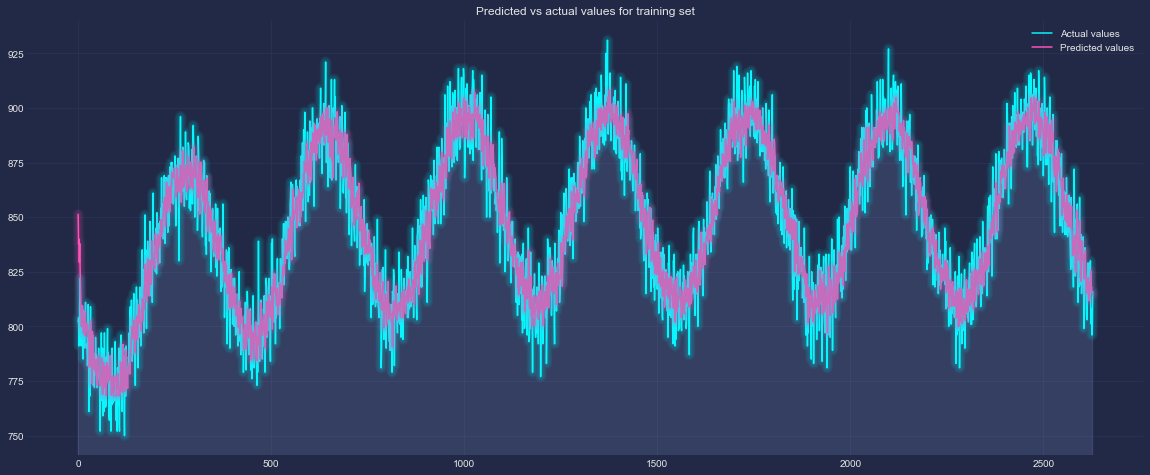

In [173]:
fig,ax= plt.subplots(figsize=[20,8])
ax.plot(y_train.values,label='Actual values')
ax.plot(train_preds,label='Predicted values')
ax.legend()
ax.set_title("Predicted vs actual values for training set")
mplcyberpunk.add_glow_effects()

### Validation set plot

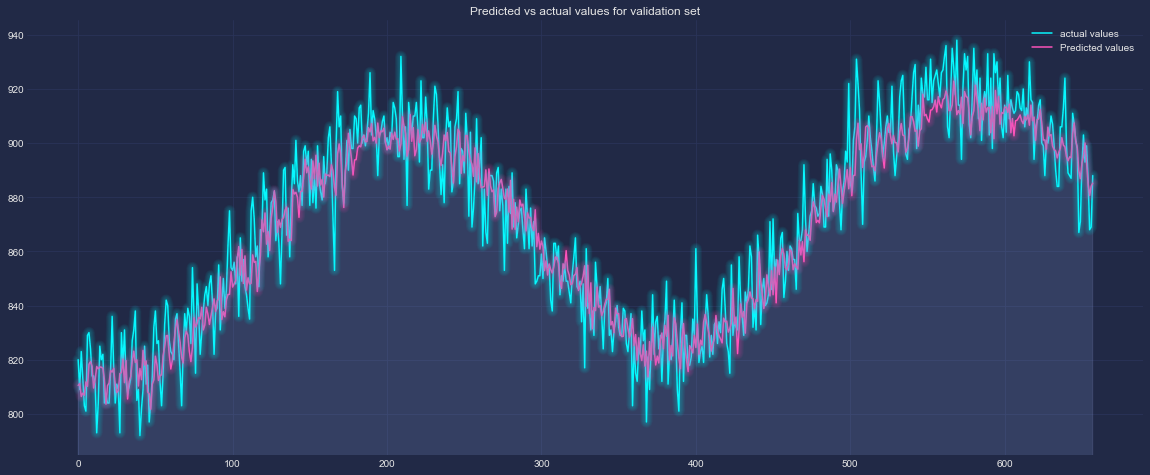

In [174]:
fig,ax= plt.subplots(figsize=[20,8])
ax.plot(y_val.values,label='actual values')
ax.plot(val_preds,label='Predicted values')
ax.legend()
ax.set_title("Predicted vs actual values for validation set")
mplcyberpunk.add_glow_effects()

## 2.LSTM model

The LSTM seems to be predicting a constant value for any variation of model size, specifications. Comparing the result once we scale the training and validation data

In [152]:
scalerX=MinMaxScaler()
scalerY=MinMaxScaler()

X_train_2, y_train_2 = np.array(X_train), np.array(y_train)
X_val_2, y_val_2 = np.array(X_val), np.array(y_val)

X_train_2=scalerX.fit_transform(X_train_2)
y_train_2=scalerY.fit_transform(y_train_2.reshape(-1,1))
X_val_2=scalerX.transform(X_val_2)
y_val_2=scalerY.transform(y_val_2.reshape(-1,1))

X_train_2=np.reshape(X_train_2,(X_train_2.shape[0],X_train_2.shape[1],1))
X_val_2=np.reshape(X_val_2,(X_val_2.shape[0],X_val_2.shape[1],1))

In [153]:
model=Sequential()
model.add(LSTM(units=2,activation='tanh',input_shape = (X_train_2.shape[1], X_train_2.shape[2]),return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64,activation='tanh', return_sequences = True ))
model.add(Dropout(0.2))
model.add(LSTM(units = 32,activation='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 32,activation='tanh',return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 32,activation='tanh',return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50,activation='tanh',return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50,activation='tanh',return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
early_stopping=EarlyStopping( min_delta=0.1, patience=10 ,restore_best_weights=True)

In [154]:
model.fit(X_train_2, y_train_2, batch_size=20, verbose = 1, epochs = 200, validation_data= (X_val_2, y_val_2),callbacks=[early_stopping])

Epoch 1/200
132/132 [==============================] - 17s 35ms/step - loss: 0.0441 - val_loss: 0.0097
Epoch 2/200
132/132 [==============================] - 2s 18ms/step - loss: 0.0116 - val_loss: 0.0076
Epoch 3/200
132/132 [==============================] - 2s 17ms/step - loss: 0.0106 - val_loss: 0.0079
Epoch 4/200
132/132 [==============================] - 2s 18ms/step - loss: 0.0094 - val_loss: 0.0064
Epoch 5/200
132/132 [==============================] - 2s 17ms/step - loss: 0.0088 - val_loss: 0.0061
Epoch 6/200
132/132 [==============================] - 2s 18ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 7/200
132/132 [==============================] - 3s 23ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 8/200
132/132 [==============================] - 3s 23ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 9/200
132/132 [==============================] - 3s 21ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 10/200
132/132 [==============================] - 3s 21ms/step - loss: 0.00

In [155]:
train_preds=model.predict(X_train_2)
val_preds=model.predict(X_val_2)

21/21 [==============================] - 0s 6ms/step


In [156]:
train_preds=scalerY.inverse_transform(train_preds)
val_preds=scalerY.inverse_transform(val_preds)

### Training set plot

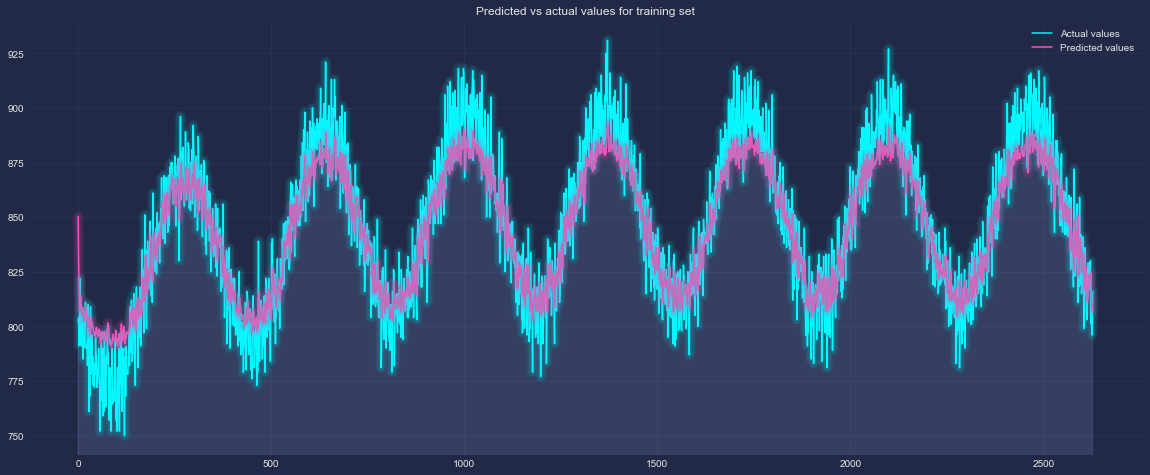

In [157]:
fig,ax= plt.subplots(figsize=[20,8])
ax.plot(y_train.values,label='Actual values')
ax.plot(train_preds,label='Predicted values')
ax.legend()
ax.set_title("Predicted vs actual values for training set")
mplcyberpunk.add_glow_effects()

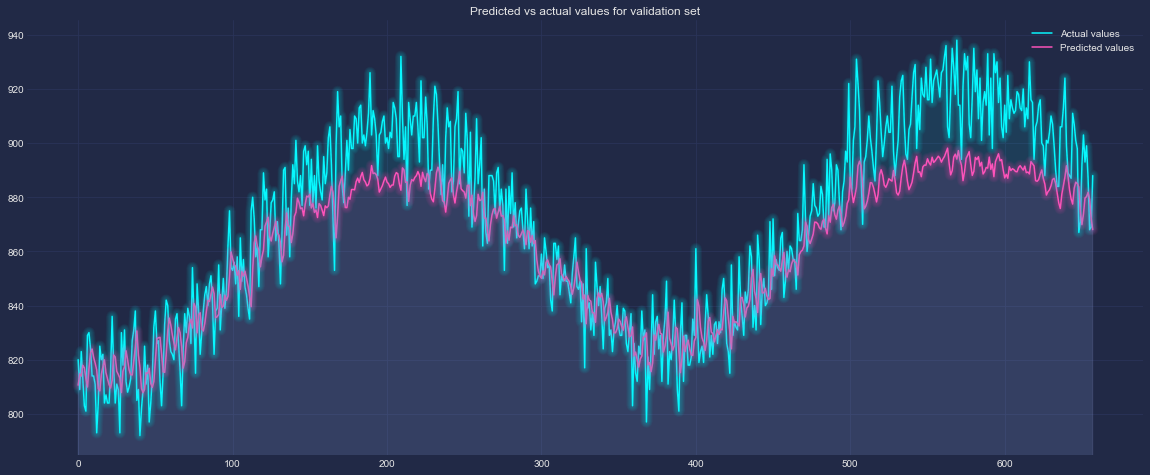

In [158]:
fig,ax= plt.subplots(figsize=[20,8])
ax.plot(y_val.values,label='Actual values')
ax.plot(val_preds,label='Predicted values')
ax.legend()
ax.set_title("Predicted vs actual values for validation set")
mplcyberpunk.add_glow_effects()

## 3.ARMA model

We need to check if the TS is stationary or not

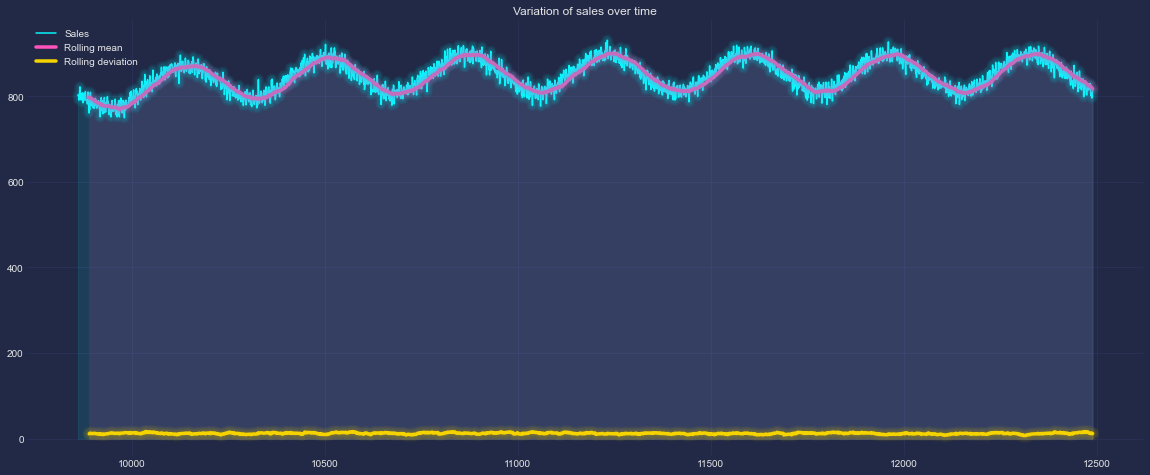

In [159]:
first_sales=y_train 
avg_month=first_sales.rolling(30).mean()
std_month=first_sales.rolling(30).std()
fig, ax= plt.subplots(figsize=[20,8])
ax.plot(first_sales,label="Sales")
ax.plot(avg_month,label="Rolling mean",linewidth=3.5)
ax.plot(std_month,label="Rolling deviation",linewidth=3.5)
ax.legend()
ax.set_title("Variation of sales over time")
mplcyberpunk.add_glow_effects()

### ADFT test

In [160]:
dftest=adfuller(y_train)
print("The probability value is {}".format(dftest[1]))
print("The lags is {}".format(dftest[2]))

The probability value is 0.01077157125240377
The lags is 25


From this we can say that p<0.05, hence the series is stationary. Now we use the ACF & PACF to find the optimum number of lags to be used.

### ACF & PACF

In [161]:
len(y_train)

2629

Text(0.5, 1.0, 'Partial auto correlation function')

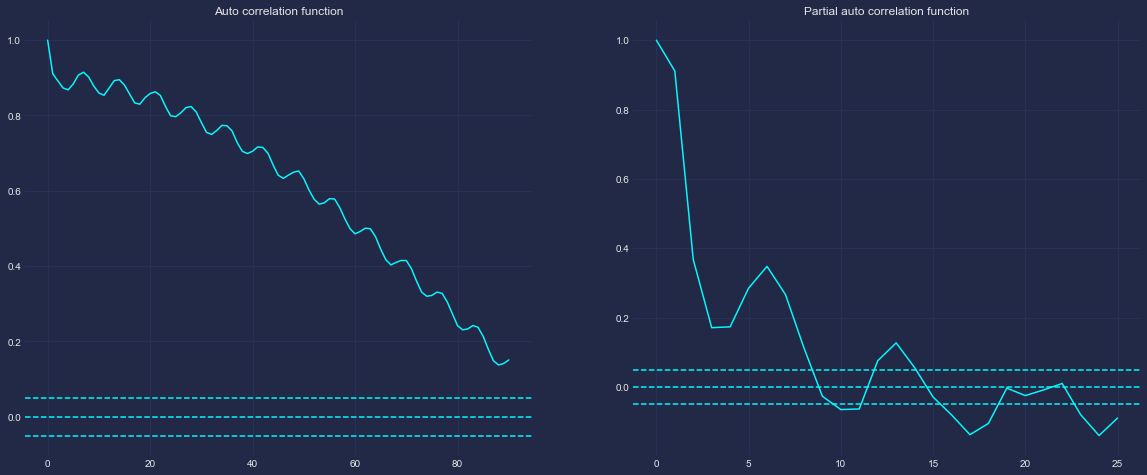

In [164]:
acf_plot=acf(y_train,nlags=90)
pacf_plot=pacf(y_train,nlags=25)

fig,ax=plt.subplots(1,2,figsize=[20,8])
ax[0].plot(acf_plot,label="ACF")
ax[0].axhline(y=0.05,linestyle='--')
ax[0].axhline(y=0,linestyle='--')
ax[0].axhline(y=-0.05,linestyle='--')
ax[0].set_title("Auto correlation function")

ax[1].plot(pacf_plot,label="PACF")
ax[1].axhline(y=0.05,linestyle='--')
ax[1].axhline(y=0,linestyle='--')
ax[1].axhline(y=-0.05,linestyle='--')
ax[1].set_title("Partial auto correlation function")


From this we see that the ACF plot meets y=0.05 at around x=132 and for PACF it meets at x=8.
Taking P as 132 and Q as 8

### (i) AR model

c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'AR model with RMSE = 19.4192642744467')

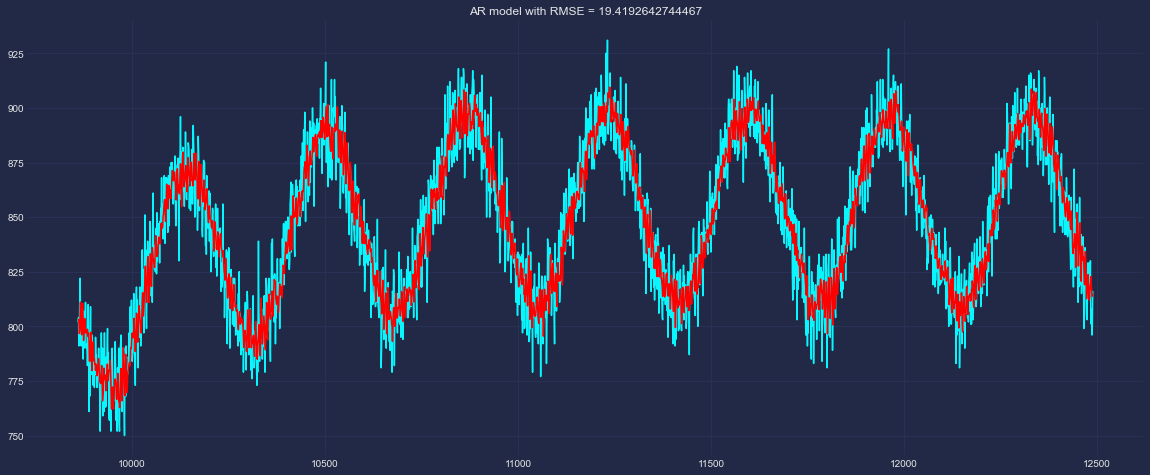

In [165]:
#AR model
ar_model=ARIMA(y_train,order=(8,1,0))
ar_predictions=ar_model.fit()

plt.figure(figsize=[20,8])
plt.plot(y_train)
plt.plot(ar_predictions.fittedvalues[1:],color='red')
RMSE=np.sqrt(sum((ar_predictions.fittedvalues-y_train)**2)/len(y_train))
plt.title("AR model with RMSE = {}".format(RMSE))

### (ii) MA model

c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'MA model with RMSE = 19.603799749778904')

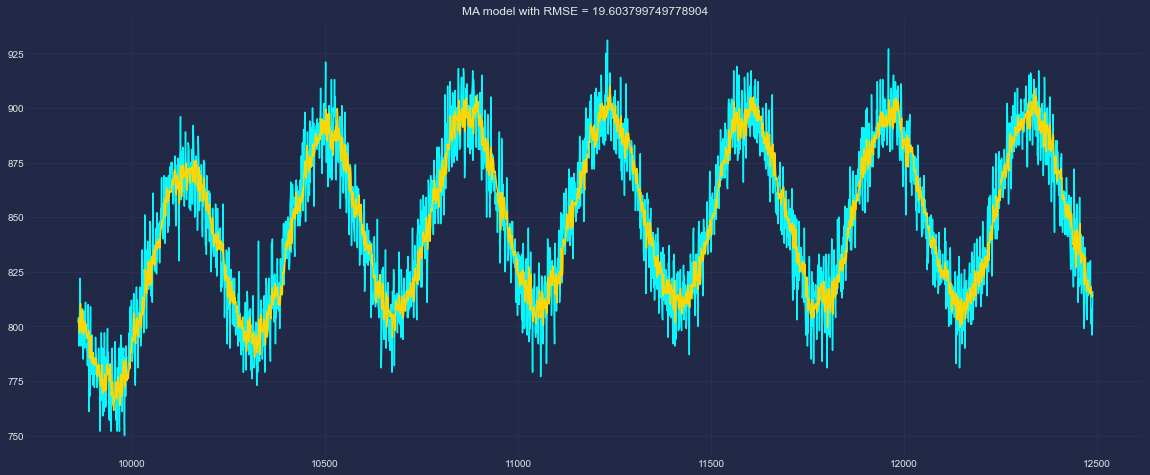

In [166]:
#MA model
ma_model=ARIMA(y_train,order=(0,1,8))
ma_predictions=ma_model.fit()

plt.figure(figsize=[20,8])
plt.plot(y_train)
plt.plot(ma_predictions.fittedvalues[1:],color='gold')
RMSE=np.sqrt(sum((ma_predictions.fittedvalues-y_train)**2)/len(y_train))
plt.title("MA model with RMSE = {}".format(RMSE))

### (iii) ARIMA model

c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ashinth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ashinth\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'ARIMA model with RMSE = 19.046509851362295')

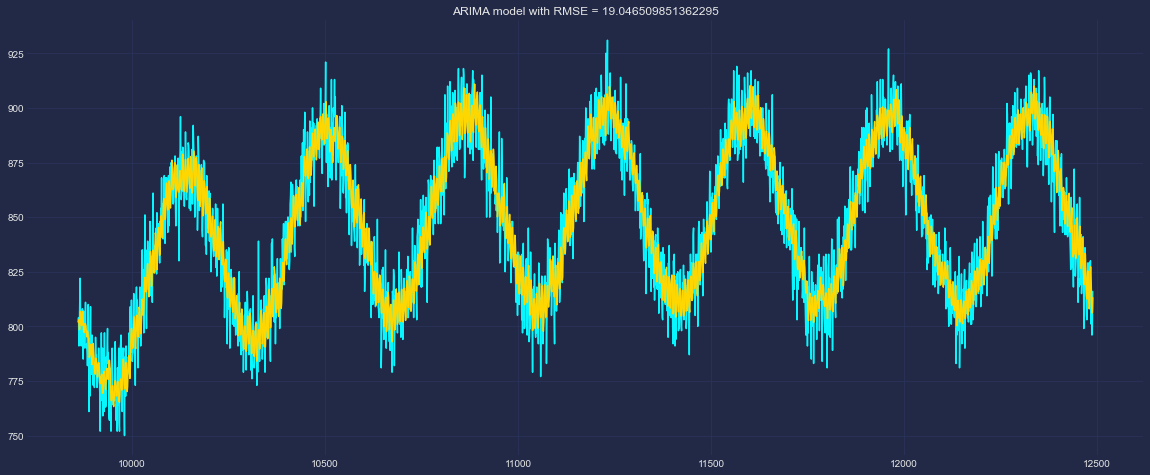

In [167]:
#ARIMA model
arima_model=ARIMA(y_train,order=(8,1,8))
arima_predictions=arima_model.fit()

plt.figure(figsize=[20,8])
plt.plot(y_train)
plt.plot(arima_predictions.fittedvalues[1:],color='gold')
RMSE=np.sqrt(sum((arima_predictions.fittedvalues-y_train)**2)/len(y_train))
plt.title("ARIMA model with RMSE = {}".format(RMSE))

from the AR and MA model, if we compare their RMSE's , the ARIMA model performs slightly better.